In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# STEP 2: Install Libraries

!pip install -q transformers
!pip install -q scikit-learn
!pip install -q nltk

# Now import essential libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary nltk resources
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# STEP 3 (Final Clean Version): Load the Train and Test datasets

# Direct loading
train_df = pd.read_excel('/content/drive/MyDrive/INFO 617/INFO 617 Group Project Train Val.xlsx')
test_df  = pd.read_excel('/content/drive/MyDrive/INFO 617/INFO 617_Group Project Test Set.xlsx')

# Quick preview to confirm
print("Train Dataset Preview:")
print(train_df.head())

print("\nTest Dataset Preview:")
print(test_df.head())

# Check columns
print("\nTrain Columns:", train_df.columns)
print("Test Columns:", test_df.columns)


Train Dataset Preview:
                                            Sentence      Label
0                                             Hello,      GREET
1   the rubella virus IgM was detected at around ...     REPEAT
2  which has a 50% chance of causing intrauterine...  DIAGNOISE
3  Intrauterine infection can lead to risks such ...    EXPLAIN
4  Please note that these risks may or may not oc...    EXPLAIN

Test Dataset Preview:
                                            Sentence      Label
0  I have calculated it for you, and your BMI is ...  DIAGNOISE
1  In this case, you need to eat more carbohydrat...      TREAT
2  Normally, you should consume 6-8 liang of stap...      TREAT
3  With this, your weight should increase by 8 li...    EXPLAIN
4  When dining outside or buying takeaway, you sh...      TREAT

Train Columns: Index(['Sentence', 'Label'], dtype='object')
Test Columns: Index(['Sentence', 'Label'], dtype='object')


In [ ]:
# STEP 4: Check Class Distribution

train_class_counts = train_df['Label'].value_counts()
print("Class Distribution in Train Set:\n")
print(train_class_counts)


Class Distribution in Train Set:

Label
TREAT                  1188
EXPLAIN                1061
DIAGNOISE               381
QUES                    267
REFERRAL                222
THANK                   145
WAIT                    139
GREET                   120
RECEIVE                 110
REPEAT                   86
CONSOLE                  78
REMIND                   78
WISH                     64
REQUEST_INFORMATION      55
FUTURE_SUPPORT           36
Name: count, dtype: int64


In [ ]:
# STEP 5: Light Synonym Replacement Augmentation

from nltk.corpus import wordnet

def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            synonym = synonym.replace("_", " ")
            if synonym != random_word:
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
        if num_replaced >= n:  # Only replace 'n' words
            break

    return ' '.join(new_words)


In [ ]:
# STEP 6 (Corrected): Carefully Augment Only Rare Classes

# First, create a copy of your training set
augmented_train_df = train_df.copy()

# Temporary list to store new augmented rows
augmented_rows = []

# Define rare classes to augment
rare_classes = ['FUTURE_SUPPORT', 'REQUEST_INFORMATION', 'WISH']

# How many augmentations we want per rare class
augmentation_target = {
    'FUTURE_SUPPORT': 30,
    'REQUEST_INFORMATION': 20,
    'WISH': 20
}

# Loop through each rare class and augment
for label in rare_classes:
    class_examples = train_df[train_df['Label'] == label]
    num_current = len(class_examples)
    num_needed = augmentation_target[label]

    print(f"\nAugmenting {label}: {num_current} examples -> +{num_needed} new examples")

    for _ in range(num_needed):
        random_row = class_examples.sample(1).iloc[0]
        original_sentence = random_row['Sentence']
        augmented_sentence = synonym_replacement(original_sentence, n=1)  # Light synonym replacement

        # Store the new row
        augmented_rows.append({
            'Sentence': augmented_sentence,
            'Label': label
        })

# Create a new DataFrame from augmented rows
augmented_rows_df = pd.DataFrame(augmented_rows)

# Concatenate original + augmented data
augmented_train_df = pd.concat([augmented_train_df, augmented_rows_df], ignore_index=True)

# Check the new shape
print(f"\nOriginal train size: {train_df.shape[0]}")
print(f"Augmented train size: {augmented_train_df.shape[0]}")



Augmenting FUTURE_SUPPORT: 36 examples -> +30 new examples

Augmenting REQUEST_INFORMATION: 55 examples -> +20 new examples

Augmenting WISH: 64 examples -> +20 new examples

Original train size: 4030
Augmented train size: 4100


In [ ]:
# STEP 7: Encode Labels

# Create label to id mapping based on updated train set
label_list = sorted(augmented_train_df['Label'].unique())
labels_to_ids = {label: idx for idx, label in enumerate(label_list)}
ids_to_labels = {idx: label for label, idx in labels_to_ids.items()}

print("Label to ID mapping:")
print(labels_to_ids)

# Map labels to IDs in both augmented train set and original test set
augmented_train_df['label_id'] = augmented_train_df['Label'].map(labels_to_ids)
test_df['label_id'] = test_df['Label'].map(labels_to_ids)

# Quick check
print("\nAugmented Train dataset after encoding:")
print(augmented_train_df[['Sentence', 'Label', 'label_id']].head())

print("\nTest dataset after encoding:")
print(test_df[['Sentence', 'Label', 'label_id']].head())


Label to ID mapping:
{'CONSOLE': 0, 'DIAGNOISE': 1, 'EXPLAIN': 2, 'FUTURE_SUPPORT': 3, 'GREET': 4, 'QUES': 5, 'RECEIVE': 6, 'REFERRAL': 7, 'REMIND': 8, 'REPEAT': 9, 'REQUEST_INFORMATION': 10, 'THANK': 11, 'TREAT': 12, 'WAIT': 13, 'WISH': 14}

Augmented Train dataset after encoding:
                                            Sentence      Label  label_id
0                                             Hello,      GREET         4
1   the rubella virus IgM was detected at around ...     REPEAT         9
2  which has a 50% chance of causing intrauterine...  DIAGNOISE         1
3  Intrauterine infection can lead to risks such ...    EXPLAIN         2
4  Please note that these risks may or may not oc...    EXPLAIN         2

Test dataset after encoding:
                                            Sentence      Label  label_id
0  I have calculated it for you, and your BMI is ...  DIAGNOISE         1
1  In this case, you need to eat more carbohydrat...      TREAT        12
2  Normally, you shou

In [ ]:
# STEP 8: Calculate Class Weights (after augmentation)

labels = augmented_train_df['label_id'].values

# Compute class weights automatically
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to Torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Print out to check
print("Class Weights (after augmentation):")
for label_idx, weight in enumerate(class_weights):
    print(f"Class: {ids_to_labels[label_idx]:20s}  |  Weight: {weight:.4f}")


Class Weights (after augmentation):
Class: CONSOLE               |  Weight: 3.5043
Class: DIAGNOISE             |  Weight: 0.7174
Class: EXPLAIN               |  Weight: 0.2576
Class: FUTURE_SUPPORT        |  Weight: 4.1414
Class: GREET                 |  Weight: 2.2778
Class: QUES                  |  Weight: 1.0237
Class: RECEIVE               |  Weight: 2.4848
Class: REFERRAL              |  Weight: 1.2312
Class: REMIND                |  Weight: 3.5043
Class: REPEAT                |  Weight: 3.1783
Class: REQUEST_INFORMATION   |  Weight: 3.6444
Class: THANK                 |  Weight: 1.8851
Class: TREAT                 |  Weight: 0.2301
Class: WAIT                  |  Weight: 1.9664
Class: WISH                  |  Weight: 3.2540


In [ ]:
# STEP 9: Load BioClinicalBERT Model and Tokenizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load BioClinicalBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Load BioClinicalBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT',
    num_labels=len(labels_to_ids)  # 15 classes
)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f" BioClinicalBERT model loaded and moved to {device}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

 BioClinicalBERT model loaded and moved to cuda


In [ ]:
# STEP 10: Build Dataset and Dataloaders

# Create custom Dataset class
class MedicalDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=60):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            sentence,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Build Train and Test Datasets
train_dataset = MedicalDataset(
    sentences=augmented_train_df['Sentence'].tolist(),
    labels=augmented_train_df['label_id'].tolist(),
    tokenizer=tokenizer,
    max_length=60
)

test_dataset = MedicalDataset(
    sentences=test_df['Sentence'].tolist(),
    labels=test_df['label_id'].tolist(),
    tokenizer=tokenizer,
    max_length=60
)

# Create DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f" Created TrainLoader with {len(train_loader)} batches.")
print(f" Created TestLoader with {len(test_loader)} batches.")


 Created TrainLoader with 257 batches.
 Created TestLoader with 75 batches.


In [ ]:
# STEP 11: Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights tensor
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss
loss_fn = FocalLoss(alpha=class_weights.to(device), gamma=2.0)

print(" Focal Loss initialized with class weights and gamma=2.0")


 Focal Loss initialized with class weights and gamma=2.0


In [ ]:
# STEP 12: Setup Optimizer, Scheduler, and Epochs

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# New Optimizer with smaller learning rate
optimizer = AdamW(model.parameters(), lr=1.5e-5)

# Number of training epochs
epochs = 10  # We'll apply Early Stopping, so it's safe

# Total number of training steps
total_steps = len(train_loader) * epochs

# Scheduler: Linear decay of learning rate

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(" Optimizer, Scheduler, and Epochs setup completed!")


 Optimizer, Scheduler, and Epochs setup completed!


In [ ]:
# STEP 13: Training Loop (Focal Loss + Early Stopping)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 3  # Early stopping patience
early_stop_counter = 0

for epoch in range(epochs):
    print(f"\n Epoch {epoch+1}/{epochs}")

    # Training
    model.train()
    total_train_loss = 0
    true_labels_train = []
    pred_labels_train = []

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        loss = loss_fn(logits, batch['labels'])

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        true_labels_train.extend(batch['labels'].detach().cpu().numpy())
        pred_labels_train.extend(preds.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = accuracy_score(true_labels_train, pred_labels_train)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    total_val_loss = 0
    true_labels_val = []
    pred_labels_val = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            loss = loss_fn(logits, batch['labels'])

            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            true_labels_val.extend(batch['labels'].detach().cpu().numpy())
            pred_labels_val.extend(preds.detach().cpu().numpy())

    avg_val_loss = total_val_loss / len(test_loader)
    val_acc = accuracy_score(true_labels_val, pred_labels_val)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_bioclincialbert_model.pt')
        print(" Validation loss decreased! Model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(" Early stopping triggered!")
            break



 Epoch 1/10
Train Loss: 0.1502 | Train Acc: 0.7646
Val Loss:   0.3769 | Val Acc:   0.7245
 Validation loss decreased! Model saved.

 Epoch 2/10
Train Loss: 0.0854 | Train Acc: 0.8156
Val Loss:   0.4019 | Val Acc:   0.7869

 Epoch 3/10
Train Loss: 0.0566 | Train Acc: 0.8629
Val Loss:   0.3573 | Val Acc:   0.7641
 Validation loss decreased! Model saved.

 Epoch 4/10
Train Loss: 0.0319 | Train Acc: 0.8868
Val Loss:   0.4118 | Val Acc:   0.7877

 Epoch 5/10
Train Loss: 0.0290 | Train Acc: 0.9061
Val Loss:   0.4194 | Val Acc:   0.8003

 Epoch 6/10
Train Loss: 0.0183 | Train Acc: 0.9285
Val Loss:   0.4259 | Val Acc:   0.8037
 Early stopping triggered!



 Classification Report on Test Set:
                     precision    recall  f1-score   support

            CONSOLE       0.53      0.89      0.67        27
          DIAGNOISE       0.55      0.80      0.65       119
            EXPLAIN       0.81      0.49      0.61       316
     FUTURE_SUPPORT       0.89      1.00      0.94         8
              GREET       1.00      0.97      0.98        29
               QUES       0.98      0.97      0.98       109
            RECEIVE       0.94      0.92      0.93        37
           REFERRAL       0.65      0.95      0.77        74
             REMIND       0.83      0.90      0.86        21
             REPEAT       0.50      0.63      0.56        30
REQUEST_INFORMATION       0.54      0.70      0.61        20
              THANK       0.93      0.95      0.94        43
              TREAT       0.80      0.82      0.81       281
               WAIT       0.94      0.85      0.89        52
               WISH       0.88      1.00      0

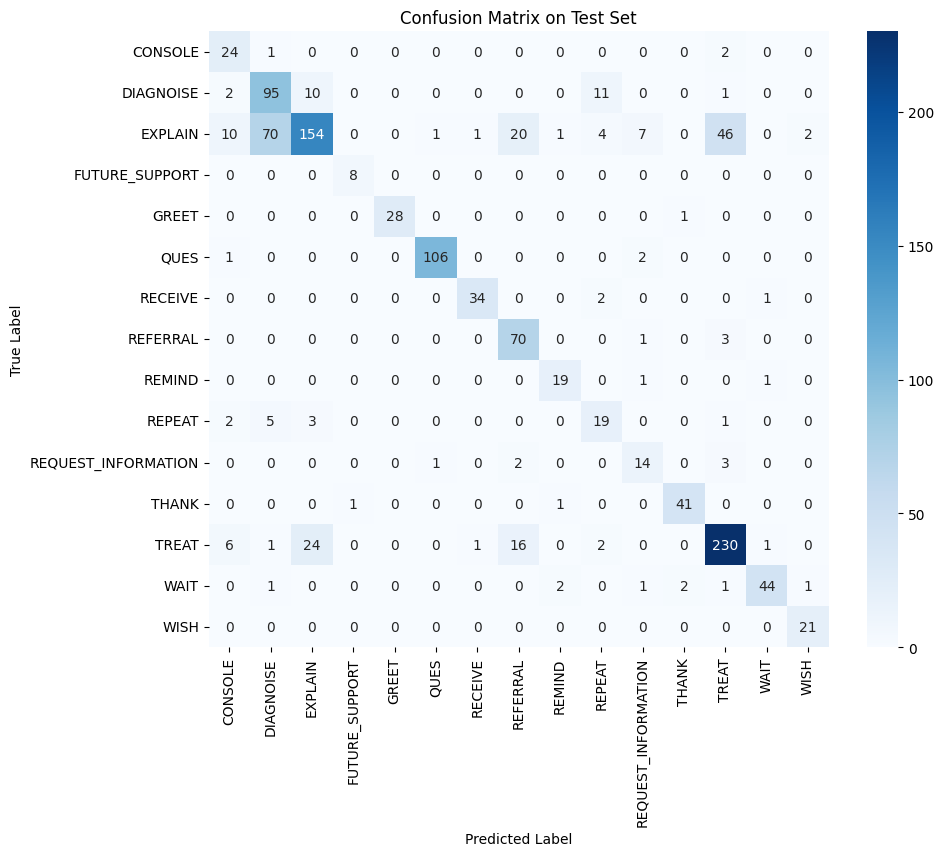

In [ ]:
# STEP 14: Load Best Model and Evaluate on Test Set

# Load the best saved model
model.load_state_dict(torch.load('best_bioclincialbert_model.pt'))
model.to(device)
model.eval()

# Predict on Test Set
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        true_labels.extend(batch['labels'].detach().cpu().numpy())
        predicted_labels.extend(preds.detach().cpu().numpy())

# Classification Report
print("\n Classification Report on Test Set:")
print(classification_report(
    true_labels, predicted_labels,
    target_names=[ids_to_labels[i] for i in range(len(ids_to_labels))]
))

# (Optional) Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[ids_to_labels[i] for i in range(len(ids_to_labels))],
            yticklabels=[ids_to_labels[i] for i in range(len(ids_to_labels))])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Set')
plt.show()
